In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import datetime as dt
import json
import os
from opendss_wrapper import OpenDSS

Last Run Plotting

In [86]:
resultsDir = 'results/'

In [91]:
buildingList = [str(i) for i in range(1,29)]
controlList = ["2", "3", "4", "5", "9", "10", "12", "15", "17", "22", "24", "25", "26", "27", "28"]

In [92]:
df_list = {}
for i in buildingList:
    temp_df = pd.read_csv(resultsDir+str(i)+'_out.csv', index_col=0)
    temp_df.index = pd.to_datetime(temp_df.index)
    df_list[i] = temp_df

In [93]:
control_list = {}
for i in controlList:
    temp_df = pd.read_csv(resultsDir+str(i)+'_control.csv', index_col=0)
    temp_df.index = pd.to_datetime(temp_df.index)
    control_list[i] = temp_df

In [94]:
bus_df = pd.read_csv(resultsDir+'main_results.csv')
activeP_df = pd.read_csv(resultsDir+'load_powers_results.csv', index_col=0)
voltage_df = pd.read_csv(resultsDir+'voltage_results.csv', index_col=0)

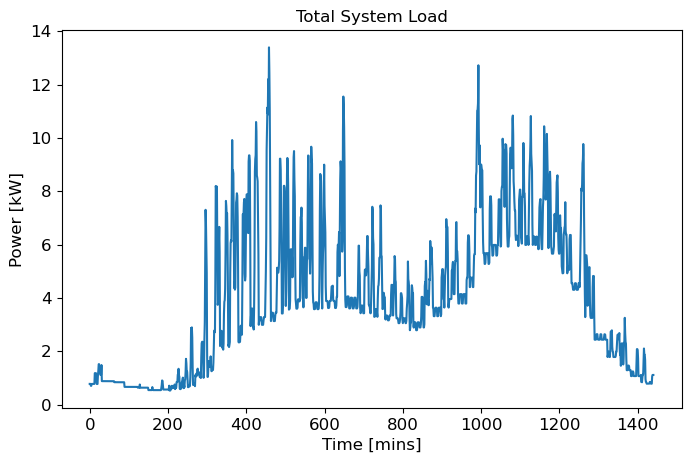

In [112]:
fs = 12
fig = plt.figure(figsize=(8,5), dpi=100)
plt.xlabel('Time [mins]', fontsize=fs)
plt.ylabel('Power [kW]', fontsize=fs)
plt.title('Total System Load', fontsize=fs)
plt.plot(bus_df['Total Load P (MW)']*1e3, label='Proposed Case')
# plt.plot(bus_df['Total Loss P (MW)'], label='Loss Power')
# plt.plot(bus_df['Total P (MW)'], label='Net Power')
# plt.plot(originalSystem_df['Total Load P (MW)'], label='original')
# plt.plot(orig_df['Total Load P (MW)'], label='Original System')
plt.tick_params(labelsize=fs)
# plt.legend(fontsize=fs)
fig.patch.set_facecolor('white')

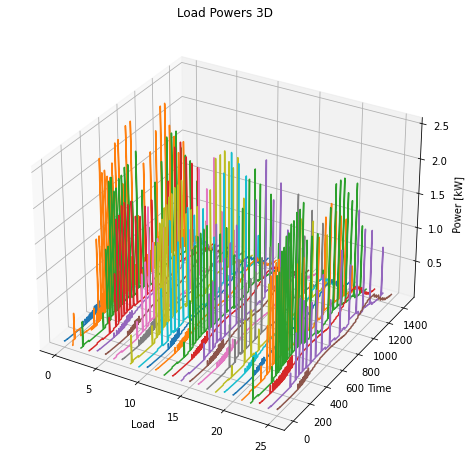

In [110]:
plt.figure(figsize=(8,8))
time = np.linspace(1,len(activeP_df), len(activeP_df))
ax = plt.axes(projection='3d')
ax.set(xlabel='Load', ylabel='Time', zlabel='Power [kW]', title="Load Powers 3D")
for i,col in enumerate(activeP_df.columns):
    # if col in controlList:
    #     color = 'tab:orange'
    # else:
    #     color = 'tab:blue'
    ax.plot3D(i*np.ones(len(time)), time, activeP_df[col])

Text(0, 0.5, 'Active Power [kW]')

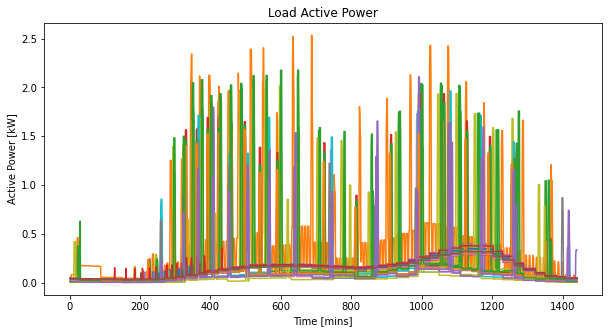

In [97]:
plt.figure(figsize=(10,5))
plt.plot(activeP_df)
plt.title('Load Active Power')
plt.xlabel('Time [mins]')
plt.ylabel('Active Power [kW]')

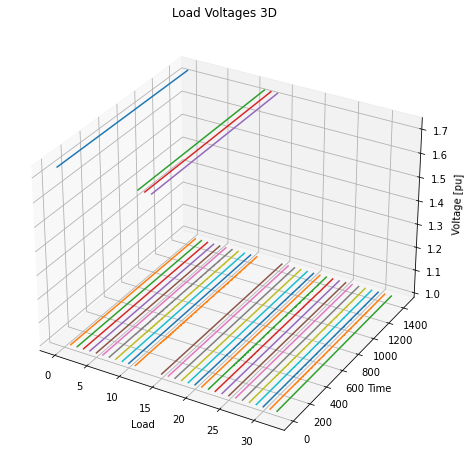

In [98]:
plt.figure(figsize=(8,8))
time = np.linspace(1,len(voltage_df), len(voltage_df))
ax = plt.axes(projection='3d')
ax.set(xlabel='Load', ylabel='Time', zlabel='Voltage [pu]', title="Load Voltages 3D")
for i,col in enumerate(voltage_df.columns):
    ax.plot3D(i*np.ones(len(time)), time, voltage_df[col])

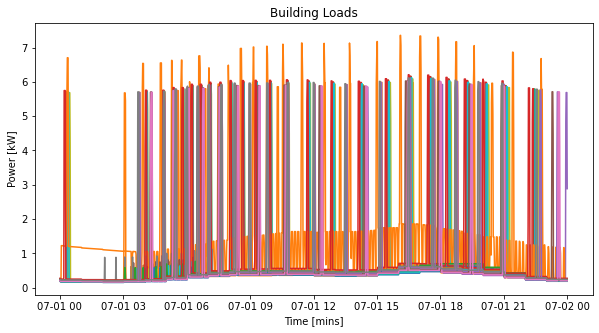

In [99]:
fig = plt.figure(figsize=(10,5))
plt.xlabel('Time [mins]')
plt.ylabel('Power [kW]')
plt.title('Building Loads')
for key, value in df_list.items():
    plt.plot(value['Whole Building Electricity'], label=str(i))
fig.patch.set_facecolor('white')

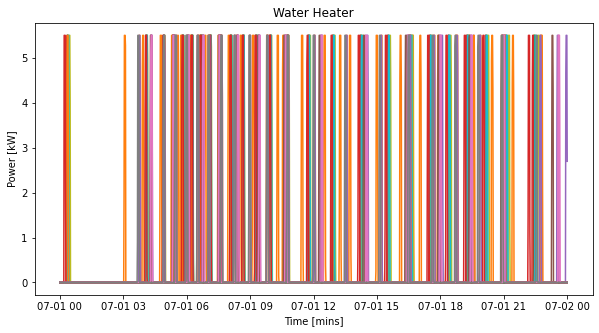

In [100]:
fig = plt.figure(figsize=(10,5))
plt.xlabel('Time [mins]')
plt.ylabel('Power [kW]')
plt.title('Water Heater')
for key, values in df_list.items():
    plt.plot(values['WaterSystems:Electricity'], label=str(i))
fig.patch.set_facecolor('white')

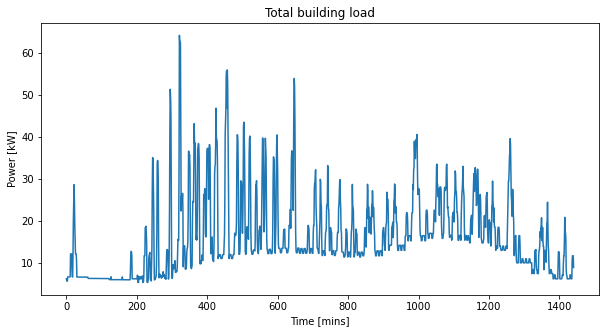

In [101]:
plt.figure(figsize=(10,5))
plt.xlabel('Time [mins]')
plt.ylabel('Power [kW]')
plt.title('Total building load')
temp = df_list['1']['Whole Building Electricity'].to_numpy(copy=True)
for i in buildingList[1:]:
    temp += df_list[i]['Whole Building Electricity'].to_numpy(copy=True)
# plt.xlim([800,1000])
plt.plot(temp, label='new')
# plt.legend()

Text(0.5, 1.0, 'Outdoor Temperature')

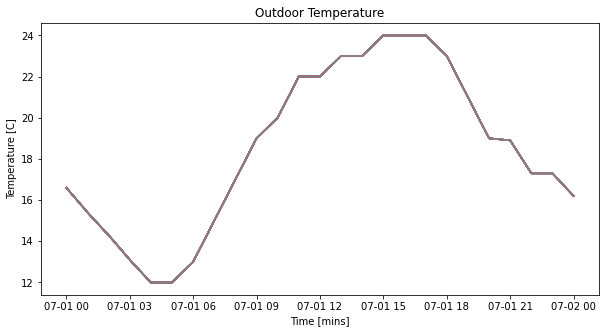

In [102]:
plt.figure(figsize=(10,5))
for key, value in df_list.items():
    plt.plot(value['Site Outdoor Air Temperature'], label=str(i))
plt.xlabel('Time [mins]')
plt.ylabel('Temperature [C]')
plt.title('Outdoor Temperature')

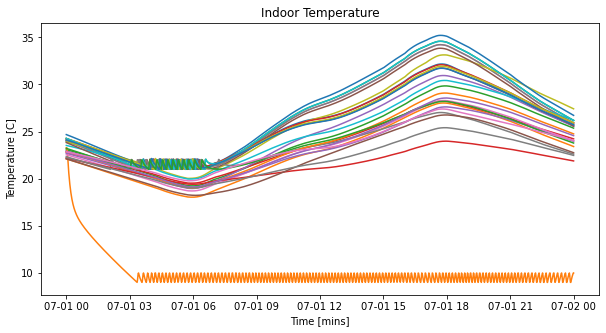

In [103]:
fig = plt.figure(figsize=(10,5))
plt.title('Indoor Temperature')
plt.ylabel('Temperature [C]')
plt.xlabel('Time [mins]')
for key, value in df_list.items():
    plt.plot(value["living space Air Temperature"])
fig.patch.set_facecolor('white')

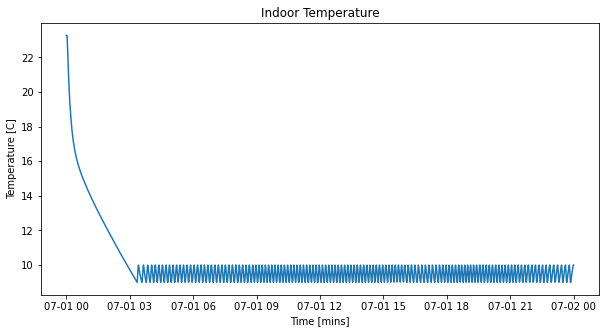

In [104]:
fig = plt.figure(figsize=(10,5))
plt.title('Indoor Temperature')
plt.ylabel('Temperature [C]')
plt.xlabel('Time [mins]')
plt.plot(df_list['12']["living space Air Temperature"])
fig.patch.set_facecolor('white')

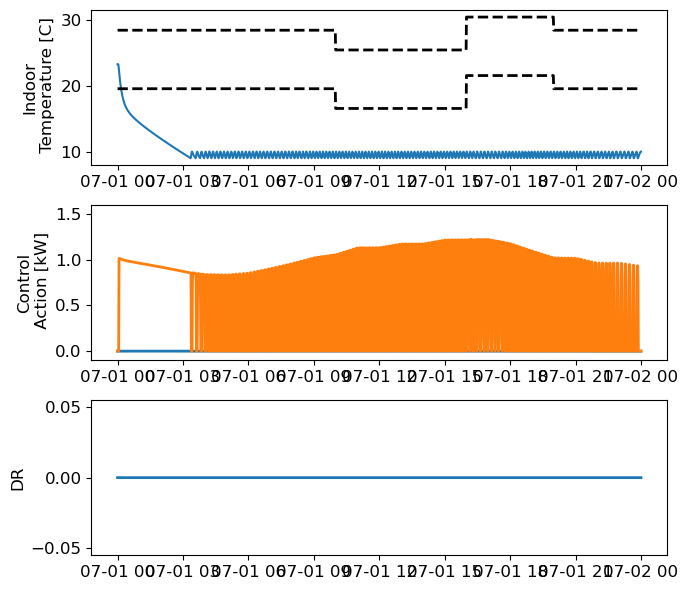

In [108]:
fig, ax = plt.subplots(3,figsize=(7,6), dpi=100)
lw = 2
fs = 12
# for i in buildingList:
i = '12'
ax[0].plot(df_list[i]['living space Air Temperature'], label='True temp')
ax[0].plot(control_list[i]['Ymax'], '--', linewidth=lw, c='k')
ax[0].plot(control_list[i]['Ymin'], '--', linewidth=lw, c='k')
ax[0].set_ylabel('Indoor\n Temperature [C]', fontsize=fs)
ax[0].tick_params(axis='x', labelsize=fs)
ax[0].tick_params(axis='y', labelsize=fs)
# ax[0].set_xlim(400, 1000)
ax[1].plot(control_list[i]['Control Effort'], linewidth=lw, label='Controller')
ax[1].plot(df_list[i]['Electricity:HVAC'], linewidth=lw, label='Actual')
ax[1].set_ylabel('Control\n Action [kW]', fontsize=fs)
ax[1].tick_params(axis='x', labelsize=fs)
ax[1].tick_params(axis='y', labelsize=fs)
# ax[1].set_xlim(400, 1000)
ax[1].set_ylim(-0.1,1.6)
# ax[1].legend(fontsize=fs)
ax[2].plot(control_list[i]['dr'], linewidth=lw)
ax[2].set_ylabel('DR', fontsize=fs)
ax[2].tick_params(axis='x', labelsize=fs)
ax[2].tick_params(axis='y', labelsize=fs)
# ax[2].set_xlim(400, 1000)
fig.patch.set_facecolor('white')
plt.tight_layout()

Training Data Plotting

In [3]:
df_list = []
for i in range(1,29):
    temp_df = pd.read_csv('results/summer/'+str(i)+'_out.csv', index_col=0)
    temp_df.index = pd.to_datetime(temp_df.index)
    df_list.append(temp_df)

In [4]:
df_list[0].keys()

Index(['heating setpoint', 'cooling setpoint', 'Whole Building Electricity',
       'Site Outdoor Air Temperature',
       'furnace airloop Discharge Air Flow Sensor',
       'furnace airloop Discharge Air Temp Sensor',
       'living space Air Temperature', 'living space Humidity',
       'living space Temperature Setpoint',
       'furnace airloop ret air zone Air Temperature',
       'furnace airloop ret air zone Humidity',
       'crawlspace - unvented Air Temperature',
       'crawlspace - unvented Humidity', 'attic - vented Air Temperature',
       'attic - vented Humidity', 'Heating:Electricity',
       'WaterSystems:Electricity', 'Fans:Electricity',
       'InteriorEquipment:Electricity', 'Electricity:HVAC'],
      dtype='object')

In [5]:
building = 3

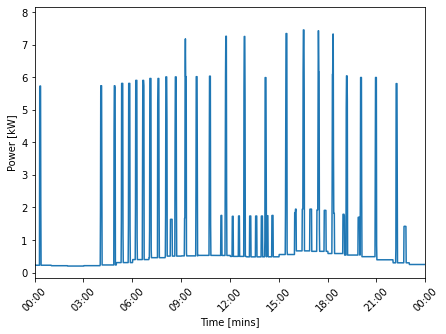

In [6]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Time [mins]')
ax.set_ylabel('Power [kW]')
ax.tick_params(axis='x', labelrotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim([mdates.datestr2num('7/01/2023 00:00'), mdates.datestr2num('7/02/2023 00:00')])
ax.plot(df_list[building].index, df_list[building]['Whole Building Electricity'])

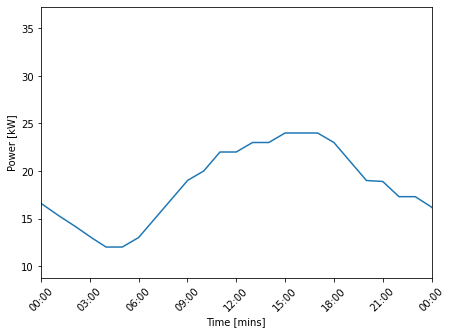

In [7]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Time [mins]')
ax.set_ylabel('Power [kW]')
ax.tick_params(axis='x', labelrotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim([mdates.datestr2num('7/01/2023 00:00'), mdates.datestr2num('7/02/2023 00:00')])
ax.plot(df_list[building].index, df_list[building]['Site Outdoor Air Temperature'])

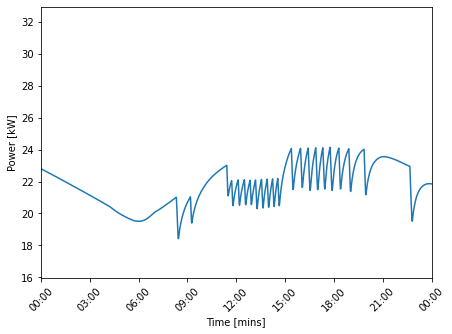

In [8]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Time [mins]')
ax.set_ylabel('Power [kW]')
ax.tick_params(axis='x', labelrotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim([mdates.datestr2num('7/01/2023 00:00'), mdates.datestr2num('7/02/2023 00:00')])
ax.plot(df_list[building].index, df_list[building]['living space Air Temperature'])

In [14]:
start_time = dt.datetime(2023, 7, 1)
duration = dt.timedelta(days=40)
dayNum = start_time.timetuple().tm_yday - 1

In [15]:
temp_df = pd.read_csv('results/randSch/hvacSch.csv', header=None, names=['heatSP', 'coolSP', 'db'])
randSP = temp_df[dayNum*24*60:(dayNum+duration.days)*24*60+1]
randSP.reset_index(inplace=True, drop=True)

temp_df = pd.read_csv('results/randSch/hvacAvail.csv', header=None, names=['avail'])
randAvail = temp_df[dayNum*24*60:(dayNum+duration.days)*24*60+1]
randAvail.reset_index(inplace=True, drop=True)

In [24]:
np.stack([randSP['heatSP'], randSP['db'], randAvail['avail']], axis=1).shape

(57601, 3)

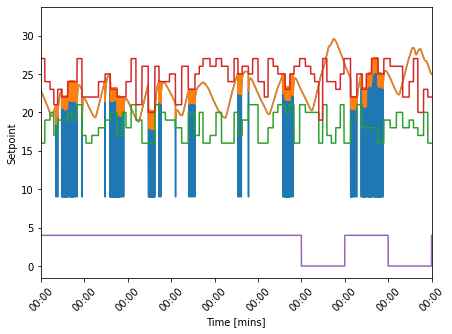

In [22]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Time [mins]')
ax.set_ylabel('Setpoint')
ax.tick_params(axis='x', labelrotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim([mdates.datestr2num('7/01/2023 00:00'), mdates.datestr2num('7/10/2023 00:00')])
ax.plot(df_list[building].index, df_list[building]['living space Temperature Setpoint'])
ax.plot(df_list[building].index, df_list[building]['living space Air Temperature'])
ax.plot(df_list[building].index, randSP['heatSP'])
ax.plot(df_list[building].index, randSP['coolSP'])
ax.plot(df_list[building].index, randAvail['avail'])

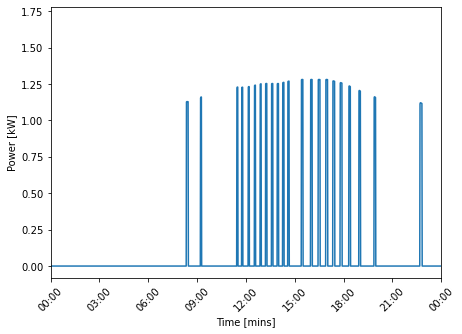

In [9]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Time [mins]')
ax.set_ylabel('Power [kW]')
ax.tick_params(axis='x', labelrotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim([mdates.datestr2num('7/01/2023 00:00'), mdates.datestr2num('7/02/2023 00:00')])
ax.plot(df_list[building].index, df_list[building]['Electricity:HVAC'])

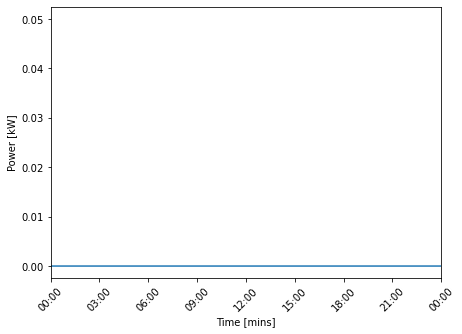

In [10]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Time [mins]')
ax.set_ylabel('Power [kW]')
ax.tick_params(axis='x', labelrotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim([mdates.datestr2num('7/01/2023 00:00'), mdates.datestr2num('7/02/2023 00:00')])
ax.plot(df_list[building].index, df_list[building]['Heating:Electricity'])

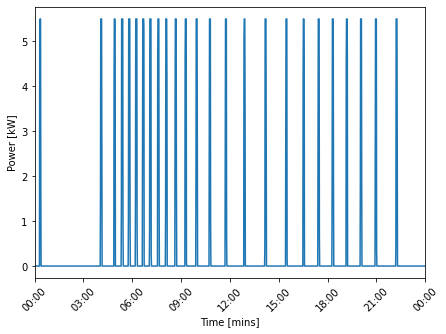

In [11]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Time [mins]')
ax.set_ylabel('Power [kW]')
ax.tick_params(axis='x', labelrotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim([mdates.datestr2num('7/01/2023 00:00'), mdates.datestr2num('7/02/2023 00:00')])
ax.plot(df_list[building].index, df_list[building]['WaterSystems:Electricity'])

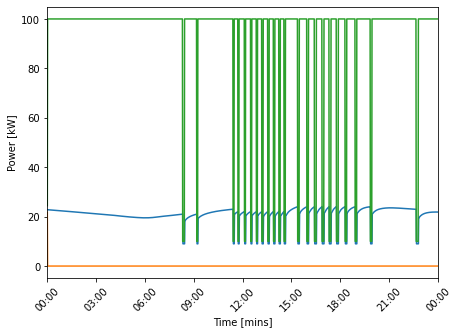

In [12]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Time [mins]')
ax.set_ylabel('Power [kW]')
ax.tick_params(axis='x', labelrotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim([mdates.datestr2num('7/01/2023 00:00'), mdates.datestr2num('7/02/2023 00:00')])
ax.plot(df_list[building].index, df_list[building]['living space Temperature Setpoint'])
ax.plot(df_list[building].index, df_list[building]['heating setpoint'])
ax.plot(df_list[building].index, df_list[building]['cooling setpoint'])

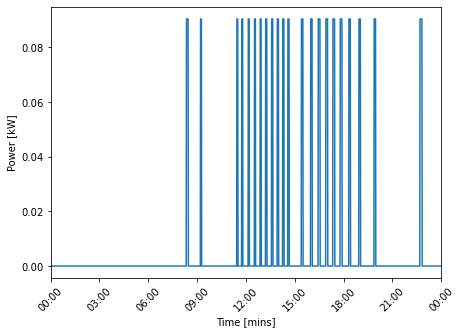

In [13]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Time [mins]')
ax.set_ylabel('Power [kW]')
ax.tick_params(axis='x', labelrotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim([mdates.datestr2num('7/01/2023 00:00'), mdates.datestr2num('7/02/2023 00:00')])
ax.plot(df_list[building].index, df_list[building]['Fans:Electricity'] * 1e-3 / 60)

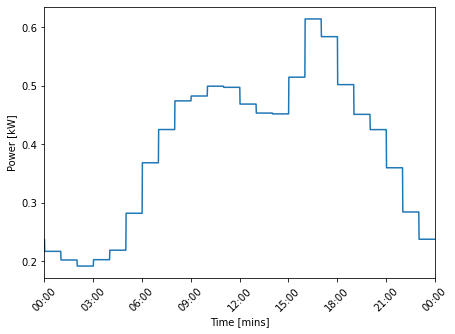

In [14]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Time [mins]')
ax.set_ylabel('Power [kW]')
ax.tick_params(axis='x', labelrotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim([mdates.datestr2num('7/01/2023 00:00'), mdates.datestr2num('7/02/2023 00:00')])
ax.plot(df_list[building].index, df_list[building]['InteriorEquipment:Electricity'] * 1e-3 / 60)

In [15]:
df_aggregate = pd.read_csv('results/aggregate_out.csv')

Text(0, 0.5, 'Whole Building Electricity')

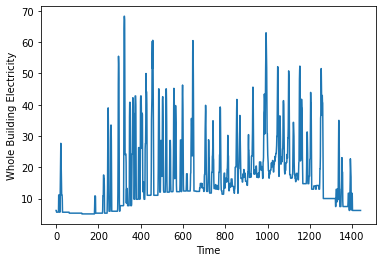

In [16]:
plt.figure()
plt.plot(df_aggregate['0'])
plt.xlabel("Time")
plt.ylabel('Whole Building Electricity')

KeyError: 'Predicted Temperature'

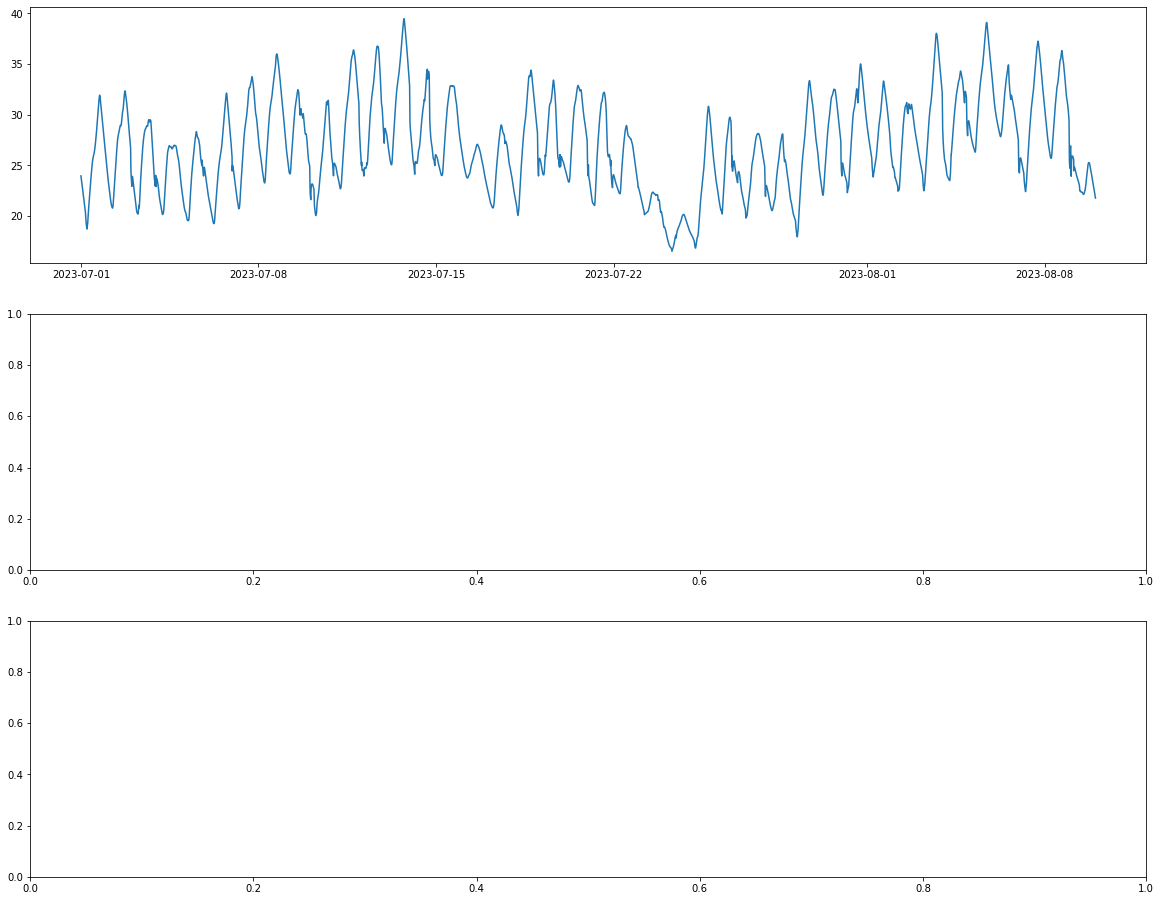

In [17]:
fig, ax = plt.subplots(3,figsize=(20,16))
# for i in range(0,len(df_list)):
i = 0
ax[0].plot(df_list[i]['living space Air Temperature'], label='True temp')
ax[0].plot(df_list[i]['Predicted Temperature'], label='Pred temp')
ax[0].plot(df_list[i]['Ymax'], '--', linewidth=3, c='k')
ax[0].plot(df_list[i]['Ymin'], '--', linewidth=3, c='k')
ax[0].set_ylabel('y', fontsize=26)
ax[0].grid(True)
ax[0].tick_params(axis='x', labelsize=26)
ax[0].tick_params(axis='y', labelsize=26)
# ax[0].set_xlim(0, 1440)
ax[1].plot(df_list[i]['Control Effort'])
ax[1].plot(df_list[i]['Heating:Electricity'])
ax[1].set_ylabel('u', fontsize=26)
ax[1].grid(True)
ax[1].tick_params(axis='x', labelsize=26)
ax[1].tick_params(axis='y', labelsize=26)
# ax[1].set_xlim(0, 1440)
ax[1].set_ylim(-0.1,1.6)
ax[2].plot(df_list[i]['Site Outdoor Air Temperature'])
ax[2].set_ylabel('d', fontsize=26)
ax[2].grid(True)
ax[2].tick_params(axis='x', labelsize=26)
ax[2].tick_params(axis='y', labelsize=26)
# ax[2].set_xlim(0, 1440)
ax[2].set_xlabel('Time [mins]', fontsize=26)
fig.patch.set_facecolor('white')

In [7]:
with open('simParams.json') as fp:
    simParams = json.load(fp)
simParams['start'] = '07/01/23'

In [9]:
start_time = dt.datetime.strptime(simParams['start'], "%m/%d/%y")
stepsize = pd.Timedelta(simParams['step'])
duration = pd.Timedelta(simParams['duration'])
end_time = start_time + duration
times = pd.date_range(start_time, freq=stepsize, end=end_time)

In [11]:
weather = pd.read_csv('results/summer/1_out.csv', usecols=['Time', 'Site Outdoor Air Temperature'])
weather['Time'] = pd.to_datetime(weather['Time'], format="%Y-%m-%d %H:%M:%S")

In [12]:
times[0]

Timestamp('2023-07-01 00:00:00', freq='T')

In [16]:
weather.loc[0, 'Time']

Timestamp('2023-07-01 00:00:00')

In [17]:
times[0] == weather.loc[0, 'Time']

True

In [18]:
weather.loc[weather['Time'] == times[0]]

,Time,Site Outdoor Air Temperature
0,2023-07-01,16.6


In [24]:
new_df = weather.set_index(weather['Time'])
new_df.drop('Time', axis=1, inplace=True)
new_df

,Site Outdoor Air Temperature
Time,
2023-07-01 00:00:00,16.60
2023-07-01 00:01:00,16.58
2023-07-01 00:02:00,16.56
2023-07-01 00:03:00,16.54
2023-07-01 00:04:00,16.52
...,...
2023-08-09 23:56:00,14.00
2023-08-09 23:57:00,14.00
2023-08-09 23:58:00,14.00


In [29]:
pos = new_df.index.get_loc(times[0])
new_df['Site Outdoor Air Temperature'].iloc[pos:pos+30].to_numpy()

array([16.6 , 16.58, 16.56, 16.54, 16.52, 16.5 , 16.48, 16.46, 16.44,
       16.42, 16.4 , 16.38, 16.36, 16.34, 16.32, 16.3 , 16.28, 16.26,
       16.24, 16.22, 16.2 , 16.18, 16.16, 16.14, 16.12, 16.1 , 16.08,
       16.06, 16.04, 16.02])

OpenDSS Plotting

In [4]:
MainDir = './'
ModelDir = os.path.join(MainDir, 'network_model')
MasterFile = os.path.join(ModelDir, 'Master.dss')
start_time = dt.datetime(2021, 1, 1)
stepsize = dt.timedelta(minutes=1)
dss = OpenDSS([MasterFile], stepsize, start_time)

2024-09-17 11:58:22.020078 - DSS: Compiling...
2024-09-17 11:58:22.020258 - DSS: Running file: ./network_model/Master.dss
2024-09-17 11:58:22.317487 - DSS: Compiled Circuit: full_network


/home/psalter/.local/lib/python3.10/site-packages/opendss_wrapper/OpenDSS.py:52: FutureWarning: The default value of regex will change from True to False in a future version.
  self.storage_names = storages.index.str.replace('Storage.', '').to_list()


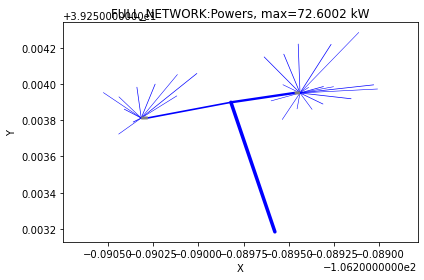

In [5]:
import dss.plot
import opendssdirect as odd
dss.plot.enable()
odd.Text.Command(f'redirect {MasterFile}')
odd.Solution.Solve()
odd.Text.Command('plot circuit powers')